# Multi Class Classification

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from mat4py import loadmat
import time
np.set_printoptions(suppress=True)

In [288]:
data = loadmat('./data/ex3data1.mat')
weights = loadmat('./data/ex3weights.mat')

X = np.array(data['X'])
y = np.array(data['y'])
# replace 10 with 0
y[y==10] = 0

Theta1 = np.array(weights['Theta1'])
Theta2 = np.array(weights['Theta2'])

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [289]:
X.shape, y.shape, ( weights.keys(), Theta1.shape, Theta2.shape)

((5000, 400),
 (5000, 1),
 (dict_keys(['Theta1', 'Theta2']), (25, 401), (10, 26)))

In [290]:
nums = np.random.choice(X.shape[0], size=100, replace=False)
images = X[nums, :]

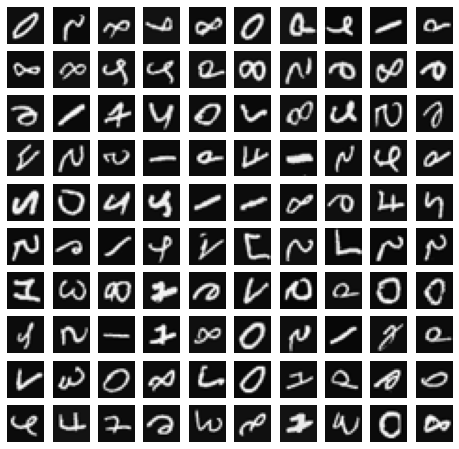

In [291]:
fig, axes = plt.subplots(10,10, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(20,20), cmap='gray')
    ax.axis("off")   # turns off axes

we will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, we will need to train 10 separate logistic regression classifiers.

In [292]:
# Logistic Regression Implementation

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iter=100000, lambda_val=0.1, fit_intercept=True):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.lambda_val = lambda_val
        self.fit_intercept = fit_intercept
        
    def __sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __cost(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        self.theta = np.zeros((X.shape[1], 1))

        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            
            h = self.__sigmoid(z)
            
            gradient = np.dot(X.T, (h - y)) / y.size
            
            gradient[1:] += (self.lambda_val/y.size) * self.theta[1:]
            
            self.theta -= self.learning_rate * gradient
            
        return self.theta
            
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [293]:
# test
theta = np.array([-2, -1, 1, 2])
lamb = 3

temp = np.arange(1,16).reshape(3,5).T/10

temp = np.column_stack((np.ones(5), temp))

y_t = np.array([1,0,1,0,1])

z = temp.dot(theta)

h =  1.0 / (1.0 + np.exp(-z))

J = (-y_t * np.log(h) - (1 - y_t) * np.log(1 - h)).mean() + (lamb/(10))*np.sum(theta[1:]**2)

gradient = np.dot(temp.T, (h - y_t)) / y_t.size
gradient[1:] += (lamb/y_t.size) * theta[1:]

J, gradient

(2.534819396109744,
 array([ 0.14656137, -0.54855841,  0.72472227,  1.39800296]))

## One Vs All

ONEVSALL trains multiple logistic regression classifiers and returns all
the classifiers in a matrix all_theta, where the i-th row of all_theta 
corresponds to the classifier for label i

In [294]:
lamb = 0.1

def oneVsAll(X, y, num_labels, lambda_val):
    all_theta = []
    
    X = np.column_stack((np.ones(X.shape[0]), X))
    
    lg = LogisticRegression(learning_rate=0.01, num_iter=4000, lambda_val=lamb, fit_intercept=False)
    
    for label in range(num_labels):
        theta = lg.fit(X, (y == label))
        all_theta.append(theta[:,0])
        
    return all_theta

In [295]:
X.shape, y.shape

((5000, 400), (5000, 1))

In [296]:
# test
t = np.column_stack((np.ones(X.shape[0]), X))

yy = (y == 0).astype(int).reshape(y.size,1)

lg = LogisticRegression(num_iter=400, lambda_val=lamb, fit_intercept=False)

theta = lg.fit(t, yy)

theta2 = np.zeros((t.shape[1],1))

for i in range(400):
    z = np.dot(t, theta)

    h = 1.0 / (1.0 + np.exp(-z))

    gradient = np.dot(t.T, (h - yy)) / yy.size

    gradient[1:] += (lamb/yy.size) * theta[1:]

    theta -= 0.01 * gradient

In [297]:
t.shape, yy.shape, theta.shape

((5000, 401), (5000, 1), (401, 1))

## prediction

In [298]:
# all theta values

start = time.process_time()

all_theta = oneVsAll(X, y, 10, 0.1)

all_theta = np.array(all_theta)

print('Time took to train: ', (time.process_time() - start)/60)

Time took to train:  9.83777859703332


In [299]:
# Make predictions on trained values

X_cpy = X.copy()

intercept = np.ones((X_cpy.shape[0], 1))
X_cpy = np.concatenate((intercept, X_cpy), axis=1)

In [300]:
all = np.dot(X_cpy, all_theta.T)

# all.shape
prob = np.amax(all, axis = 1)

pred = all.argmax(axis=1)

prob_with_index = zip(max, pred)

In [303]:
c = 0
for i in range(len(y)):
    if(y[i] == pred[i]):
        c +=1
c, (c/len(y))*100

(4405, 88.1)